# <font color='blue'> **E-Commerce Customer Segmentation & Revenue Strategy** </font>

In [4]:
import os
os.environ['SCIPY_ARRAY_API'] = '1'

In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [7]:
customer = pd.read_csv('./Ecommerce_Consumer_Behavior_Analysis_Data.csv', na_values=[], keep_default_na=False)
# To avoid pandas detecting "None" and treating it NaN 
# Without it, it looked like there were NaNs but in the csv file, there was no missing data

customer.head()

,Customer_ID,Age,Gender,Income_Level,Marital_Status,Education_Level,Occupation,Location,Purchase_Category,Purchase_Amount,Frequency_of_Purchase,Purchase_Channel,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Social_Media_Influence,Discount_Sensitivity,Return_Rate,Customer_Satisfaction,Engagement_with_Ads,Device_Used_for_Shopping,Payment_Method,Time_of_Purchase,Discount_Used,Customer_Loyalty_Program_Member,Purchase_Intent,Shipping_Preference,Time_to_Decision
0,37-611-6911,22,Female,Middle,Married,Bachelor's,Middle,Évry,Gardening & Outdoors,$333.80,4,Mixed,5,5,2.0,None,Somewhat Sensitive,1,7,None,Tablet,Credit Card,3/1/24,True,False,Need-based,No Preference,2
1,29-392-9296,49,Male,High,Married,High School,High,Huocheng,Food & Beverages,$222.22,11,In-Store,3,1,2.0,Medium,Not Sensitive,1,5,High,Tablet,PayPal,4/16/2024,True,False,Wants-based,Standard,6
2,84-649-5117,24,Female,Middle,Single,Master's,High,Huzhen,Office Supplies,$426.22,2,Mixed,5,5,0.3,Low,Not Sensitive,1,7,Low,Smartphone,Debit Card,3/15/2024,True,True,Impulsive,No Preference,3
3,48-980-6078,29,Female,Middle,Single,Master's,Middle,Wiwilí,Home Appliances,$101.31,6,Mixed,3,1,1.0,High,Somewhat Sensitive,0,1,None,Smartphone,Other,10/4/24,True,True,Need-based,Express,10
4,91-170-9072,33,Female,Middle,Widowed,High School,Middle,Nara,Furniture,$211.70,6,Mixed,3,4,0.0,Medium,Not Sensitive,2,10,None,Smartphone,Debit Card,1/30/2024,False,False,Wants-based,No Preference,4


In [8]:
customer.columns

Index(['Customer_ID', 'Age', 'Gender', 'Income_Level', 'Marital_Status',
       'Education_Level', 'Occupation', 'Location', 'Purchase_Category',
       'Purchase_Amount', 'Frequency_of_Purchase', 'Purchase_Channel',
       'Brand_Loyalty', 'Product_Rating',
       'Time_Spent_on_Product_Research(hours)', 'Social_Media_Influence',
       'Discount_Sensitivity', 'Return_Rate', 'Customer_Satisfaction',
       'Engagement_with_Ads', 'Device_Used_for_Shopping', 'Payment_Method',
       'Time_of_Purchase', 'Discount_Used', 'Customer_Loyalty_Program_Member',
       'Purchase_Intent', 'Shipping_Preference', 'Time_to_Decision'],
      dtype='object')

# <font color='blue'> Cleaning:

In [9]:
print(f"{customer.shape[0]} rows and {customer.shape[1]} columns")

1000 rows and 28 columns


# Checking for duplicates by id column

In [10]:
customer['Customer_ID'].value_counts().sort_values(ascending=False)

Customer_ID
37-611-6911    1
29-392-9296    1
84-649-5117    1
48-980-6078    1
91-170-9072    1
              ..
20-562-2569    1
41-366-4205    1
77-241-7621    1
53-091-2176    1
48-203-9118    1
Name: count, Length: 1000, dtype: int64

# Checking for NAs and Datatype

In [11]:
customer.isna().sum().sort_values(ascending=False).head()

Customer_ID       0
Age               0
Gender            0
Income_Level      0
Marital_Status    0
dtype: int64

In [12]:
customer = customer.drop(columns=['Location'])
# Dropped location as it is too specific

In [13]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Customer_ID                            1000 non-null   object 
 1   Age                                    1000 non-null   int64  
 2   Gender                                 1000 non-null   object 
 3   Income_Level                           1000 non-null   object 
 4   Marital_Status                         1000 non-null   object 
 5   Education_Level                        1000 non-null   object 
 6   Occupation                             1000 non-null   object 
 7   Purchase_Category                      1000 non-null   object 
 8   Purchase_Amount                        1000 non-null   object 
 9   Frequency_of_Purchase                  1000 non-null   int64  
 10  Purchase_Channel                       1000 non-null   object 
 11  Brand

In [14]:
# Purchase Amount: remove dollar signs and convert to float
customer['Purchase_Amount'] = customer['Purchase_Amount'].replace('[\$,]', '', regex=True).astype(float)

<>:2: SyntaxWarning: invalid escape sequence '\$'
<>:2: SyntaxWarning: invalid escape sequence '\$'
/var/folders/5p/xwv6skz53s7b388xl_g9ch540000gn/T/ipykernel_3240/609827399.py:2: SyntaxWarning: invalid escape sequence '\$'
  customer['Purchase_Amount'] = customer['Purchase_Amount'].replace('[\$,]', '', regex=True).astype(float)


In [15]:
# Create Spend Score
customer['Spend_Score'] = customer['Purchase_Amount'] * customer['Frequency_of_Purchase']

# <font color='blue'> EDA:

In [16]:
customer.describe()

,Age,Purchase_Amount,Frequency_of_Purchase,Brand_Loyalty,Product_Rating,Time_Spent_on_Product_Research(hours),Return_Rate,Customer_Satisfaction,Time_to_Decision,Spend_Score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,34.304000,275.063880,6.945000,3.026000,3.033000,1.013030,0.954000,5.399000,7.547000,1910.703370
std,9.353238,131.532998,3.147361,1.416803,1.436654,0.791802,0.810272,2.868454,4.035849,1326.767921
min,18.000000,50.710000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,102.880000
25%,26.000000,162.235000,4.000000,2.000000,2.000000,0.000000,0.000000,3.000000,4.000000,839.535000
50%,34.500000,276.165000,7.000000,3.000000,3.000000,1.000000,1.000000,5.000000,8.000000,1554.320000
75%,42.000000,388.982500,10.000000,4.000000,4.000000,2.000000,2.000000,8.000000,11.000000,2696.010000
max,50.000000,498.330000,12.000000,5.000000,5.000000,2.000000,2.000000,10.000000,14.000000,5939.640000


array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Purchase_Amount'}>,
        <Axes: title={'center': 'Frequency_of_Purchase'}>],
       [<Axes: title={'center': 'Brand_Loyalty'}>,
        <Axes: title={'center': 'Product_Rating'}>,
        <Axes: title={'center': 'Time_Spent_on_Product_Research(hours)'}>],
       [<Axes: title={'center': 'Return_Rate'}>,
        <Axes: title={'center': 'Customer_Satisfaction'}>,
        <Axes: title={'center': 'Time_to_Decision'}>],
       [<Axes: title={'center': 'Spend_Score'}>, <Axes: >, <Axes: >]],
      dtype=object)

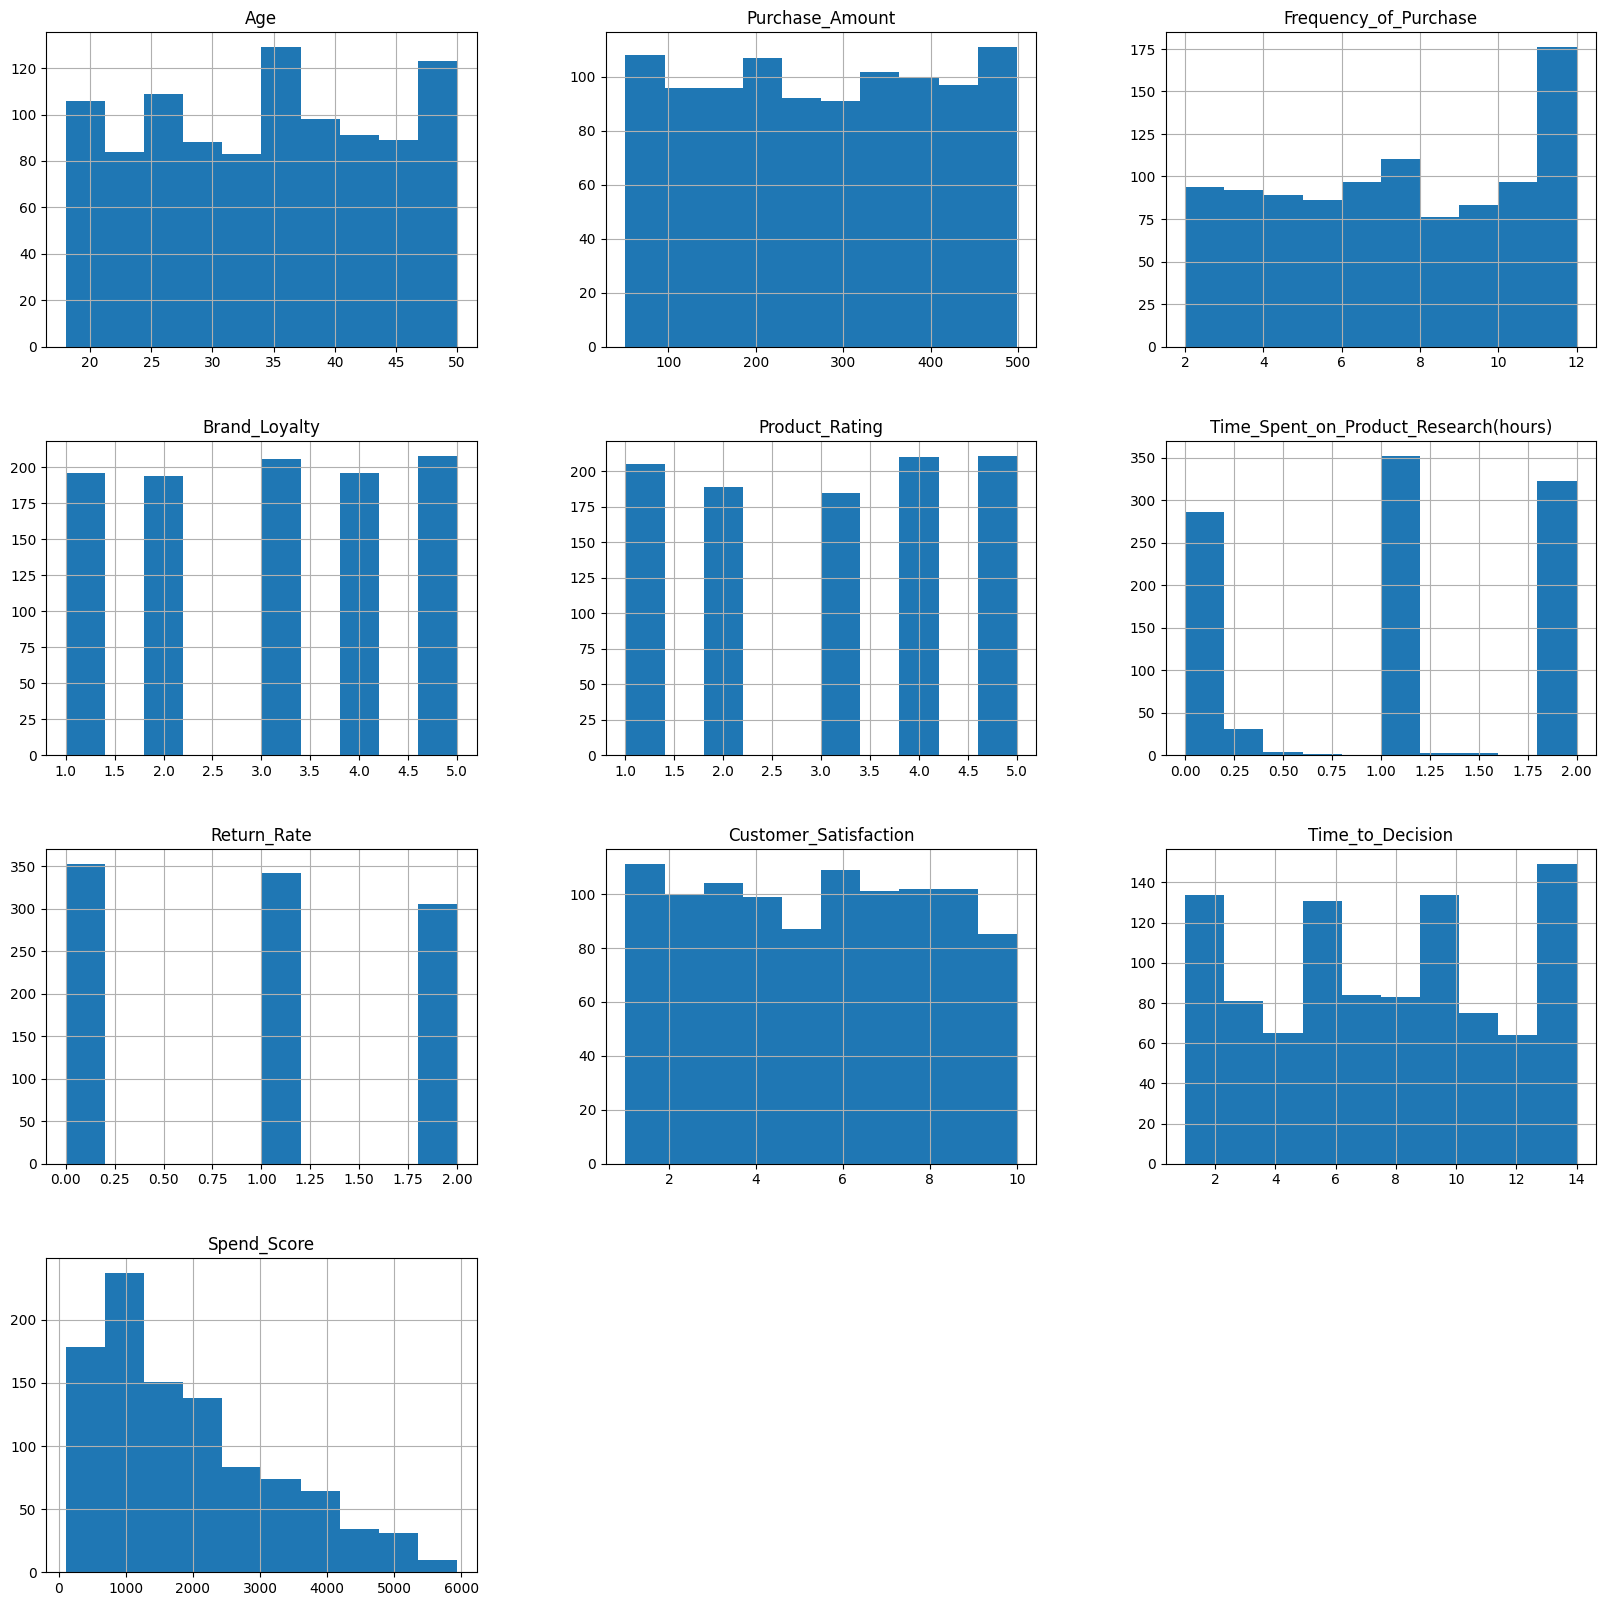

In [17]:
# Looking at distribution of data
customer.hist(figsize=(20,20))

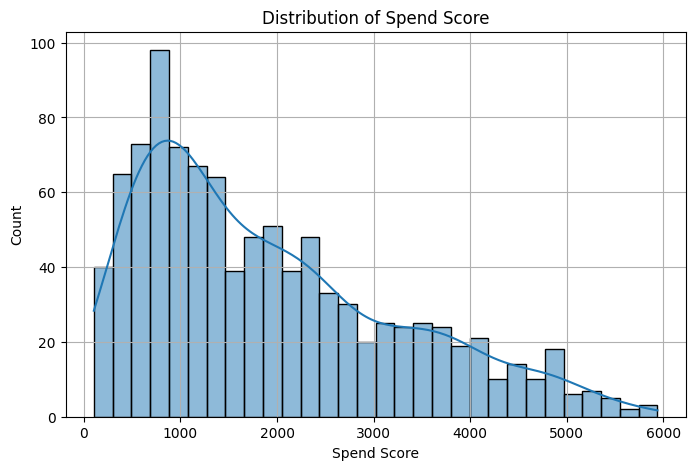

In [18]:
# Distribution of spend score
plt.figure(figsize=(8, 5))
sns.histplot(customer['Spend_Score'], kde=True, bins=30)
plt.title('Distribution of Spend Score')
plt.xlabel('Spend Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [19]:
print("Summary statistics for Spend_Score:")
print(customer['Spend_Score'].describe())

Summary statistics for Spend_Score:
count    1000.000000
mean     1910.703370
std      1326.767921
min       102.880000
25%       839.535000
50%      1554.320000
75%      2696.010000
max      5939.640000
Name: Spend_Score, dtype: float64


In [20]:
percentiles = customer['Spend_Score'].quantile([0.77, 0.78, 0.79, 0.8])
print(percentiles)

0.77    2856.9915
0.78    2940.6810
0.79    3031.7427
0.80    3092.3220
Name: Spend_Score, dtype: float64


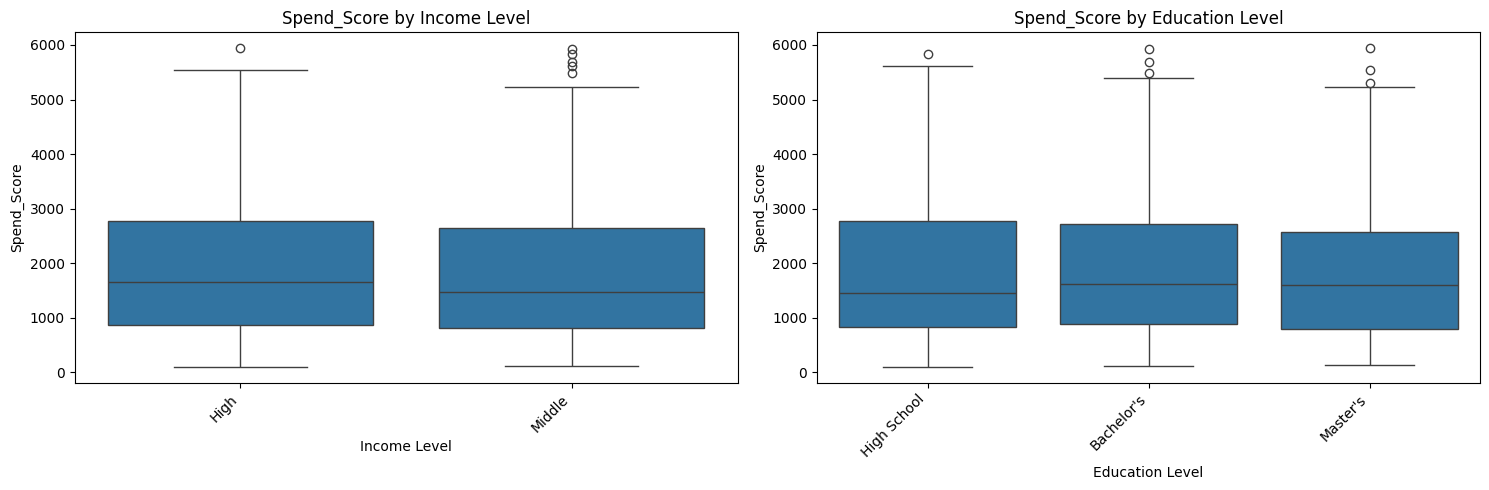

In [21]:
# Plotting relationships for a few key categorical features
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='Income_Level', y='Spend_Score', data=customer, order=customer.groupby('Income_Level')['Spend_Score'].mean().sort_values(ascending=False).index)
plt.title('Spend_Score by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Spend_Score')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
sns.boxplot(x='Education_Level', y='Spend_Score', data=customer, order=customer.groupby('Education_Level')['Spend_Score'].mean().sort_values(ascending=False).index)
plt.title('Spend_Score by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Spend_Score')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show() 

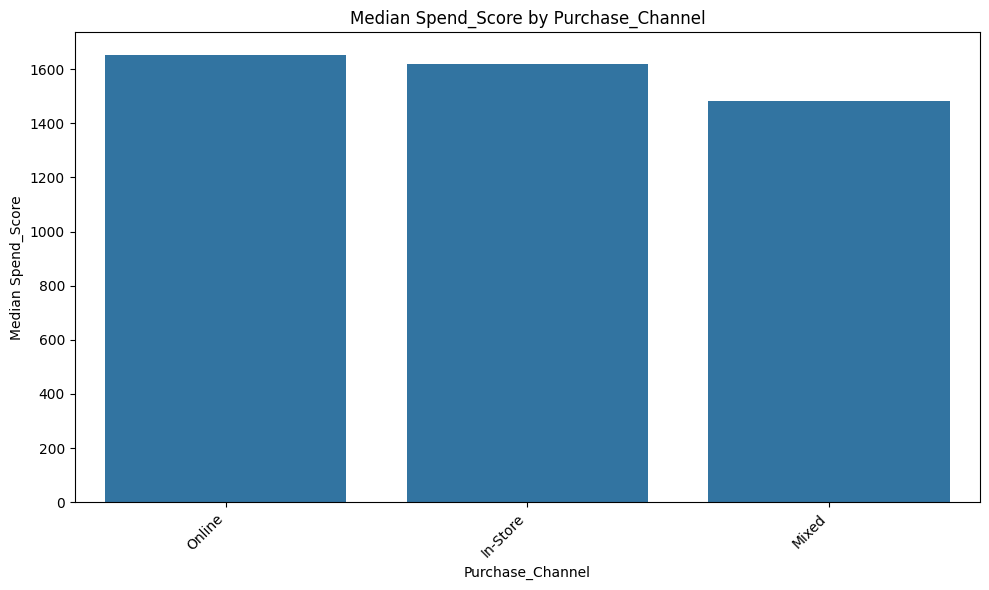

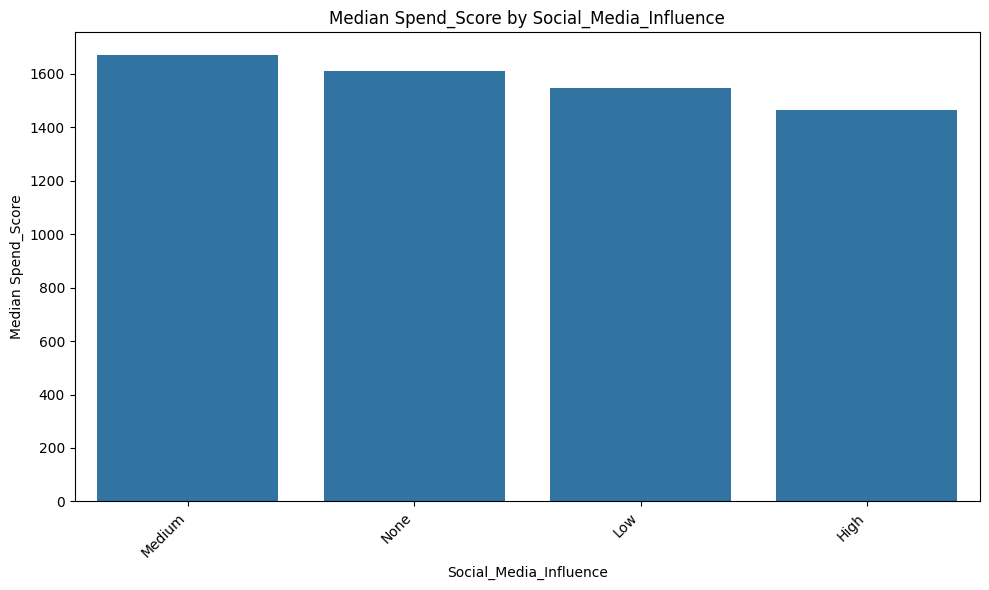

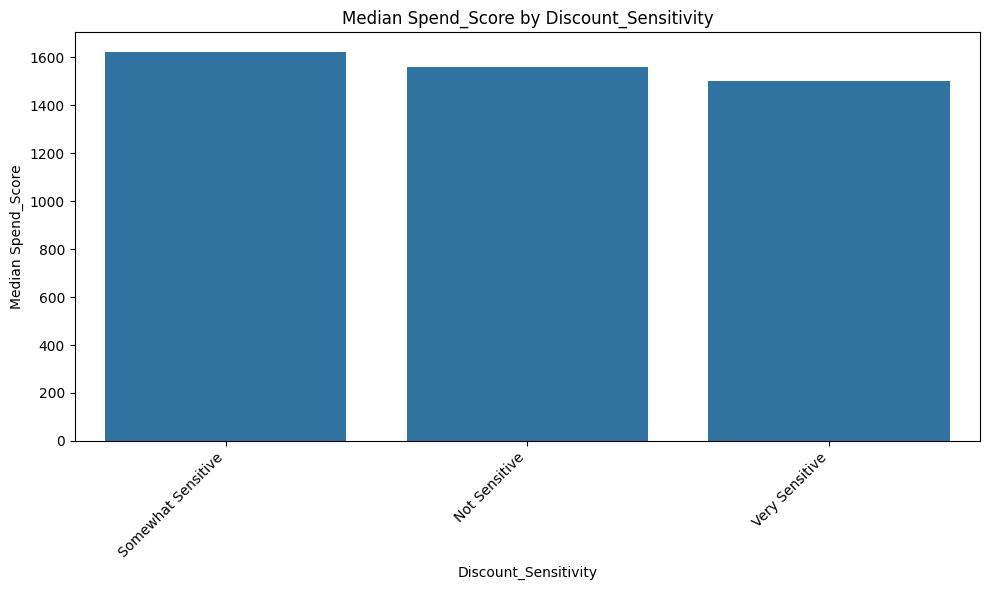

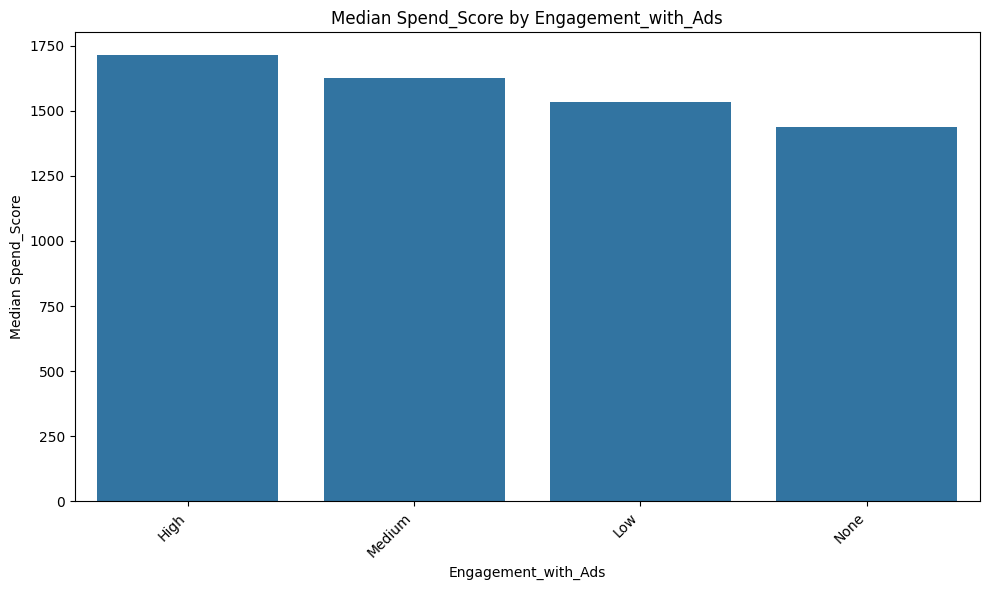

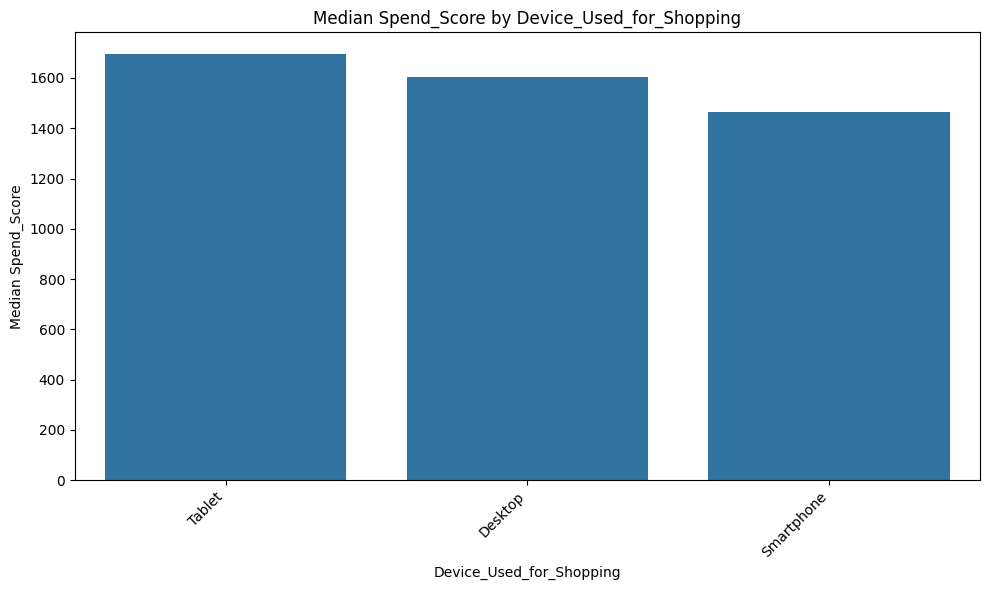

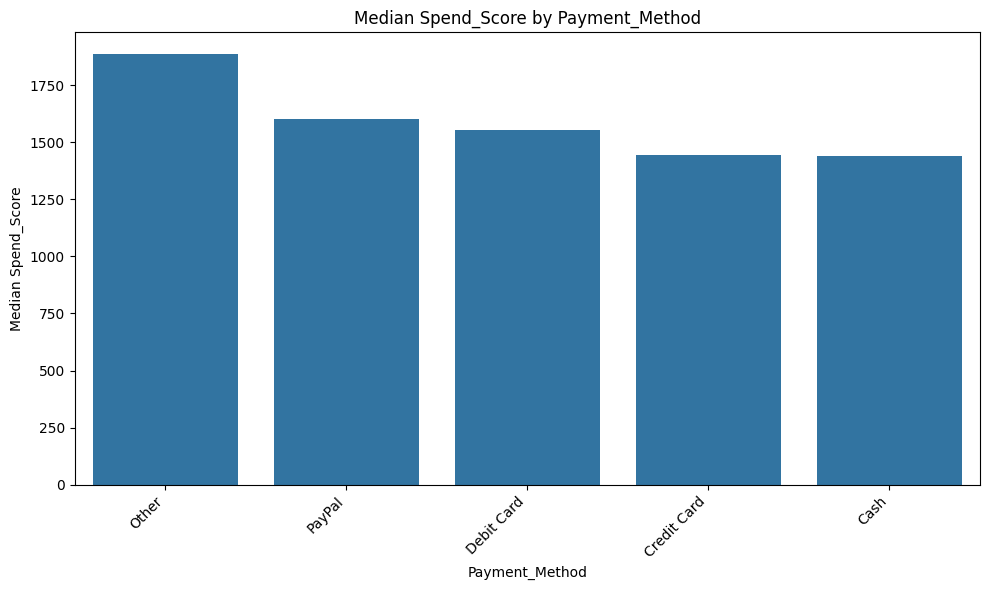

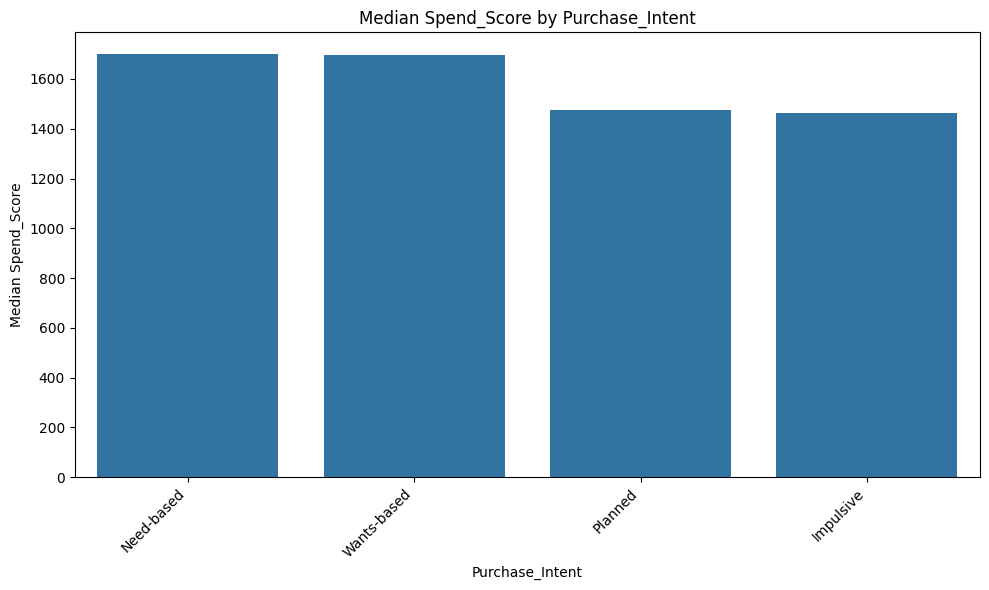

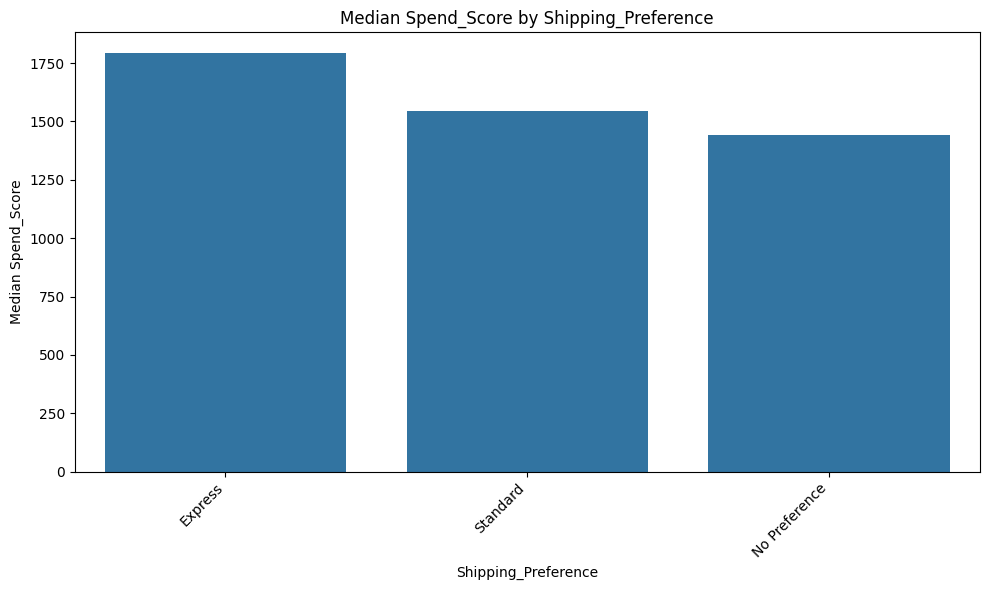

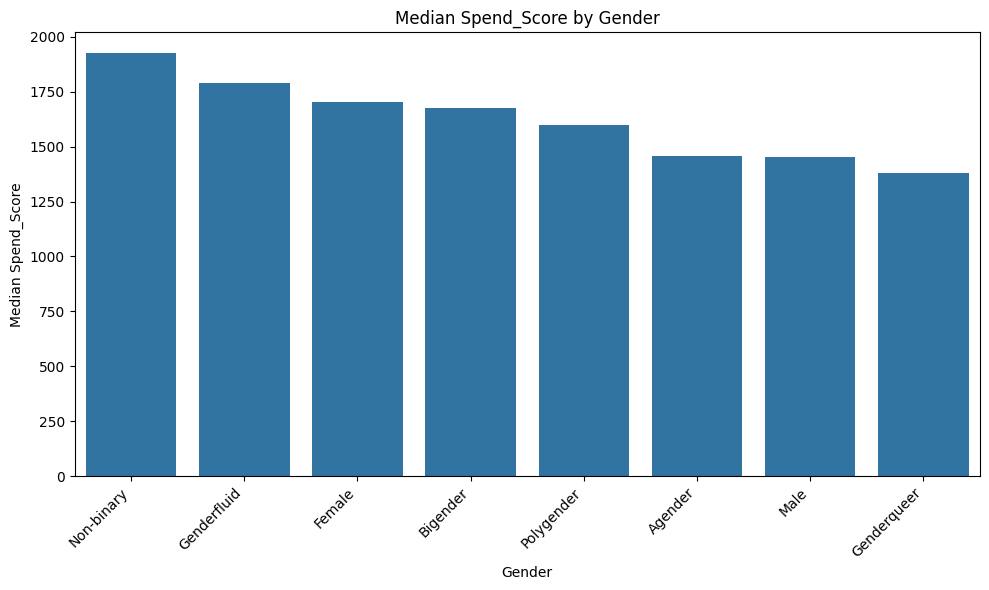

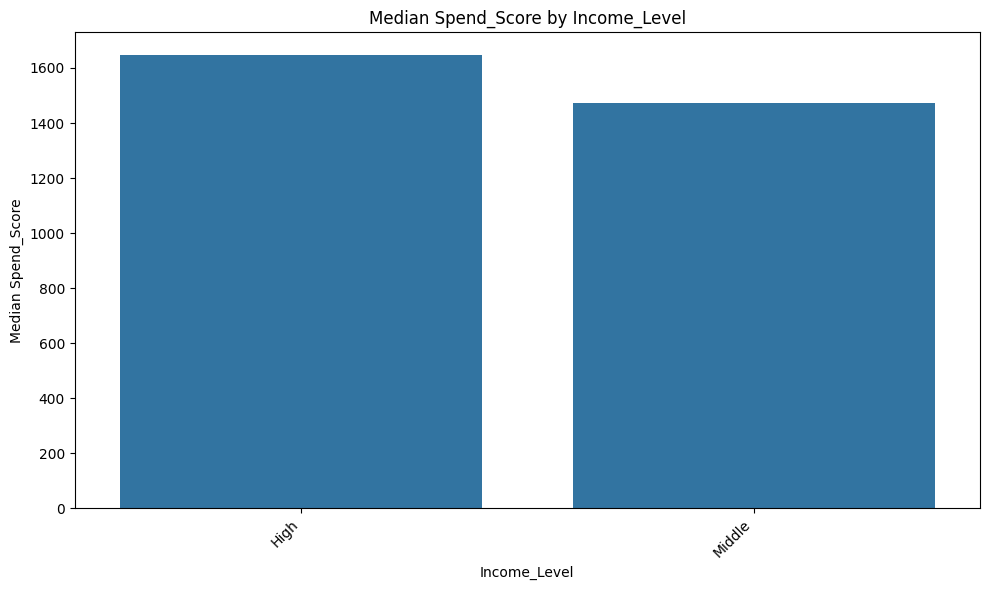

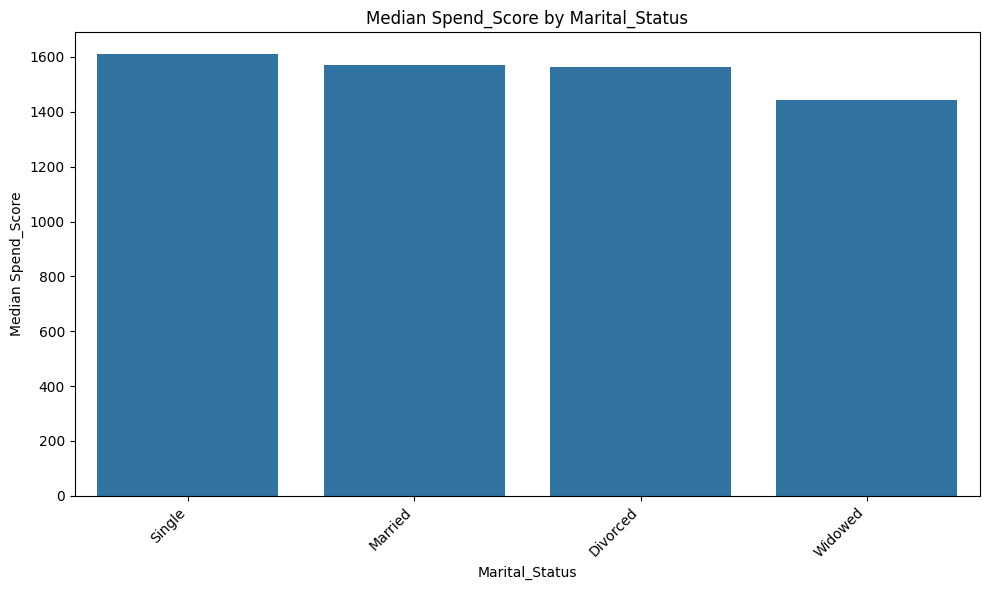

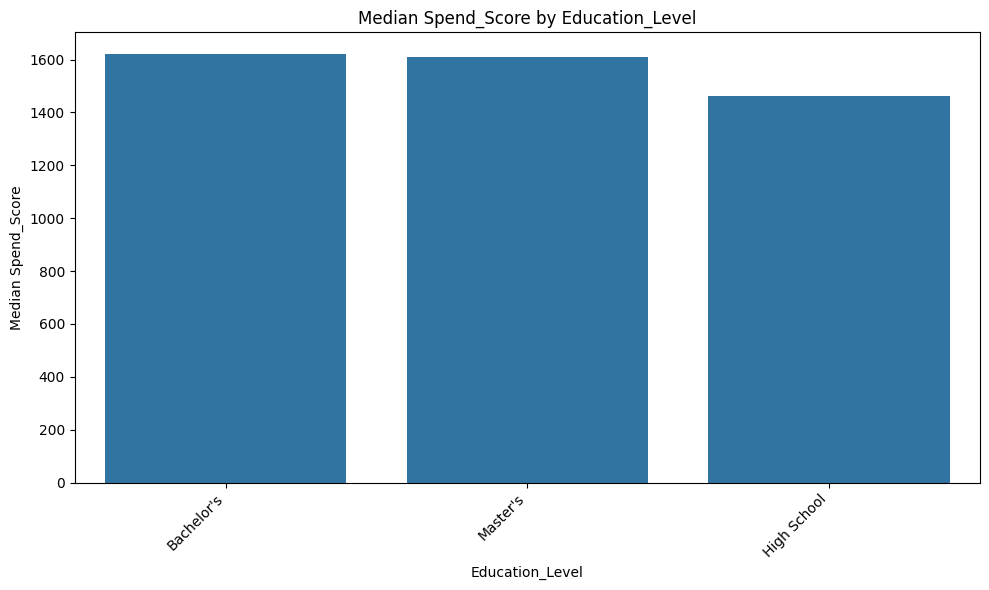

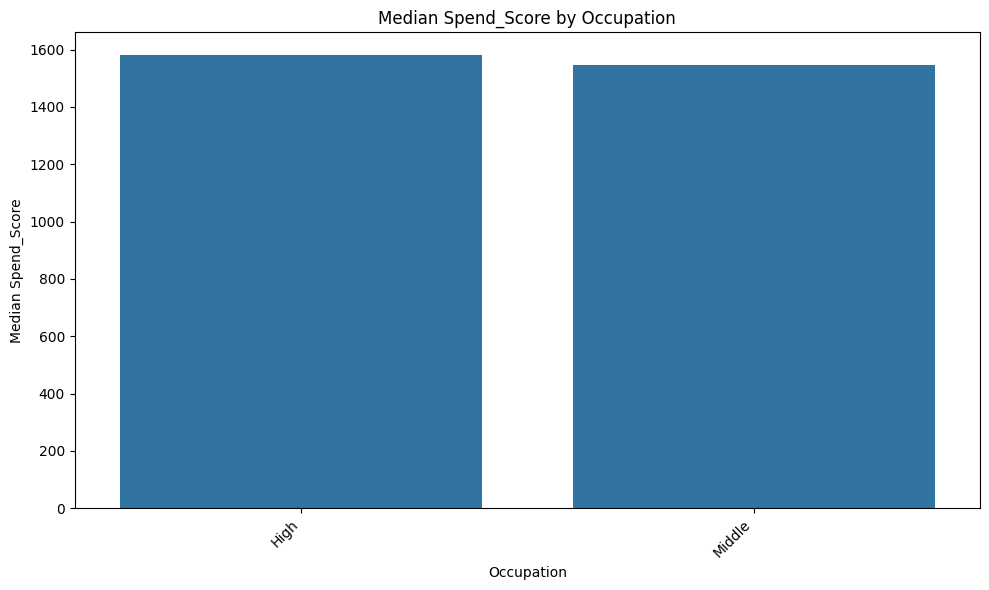

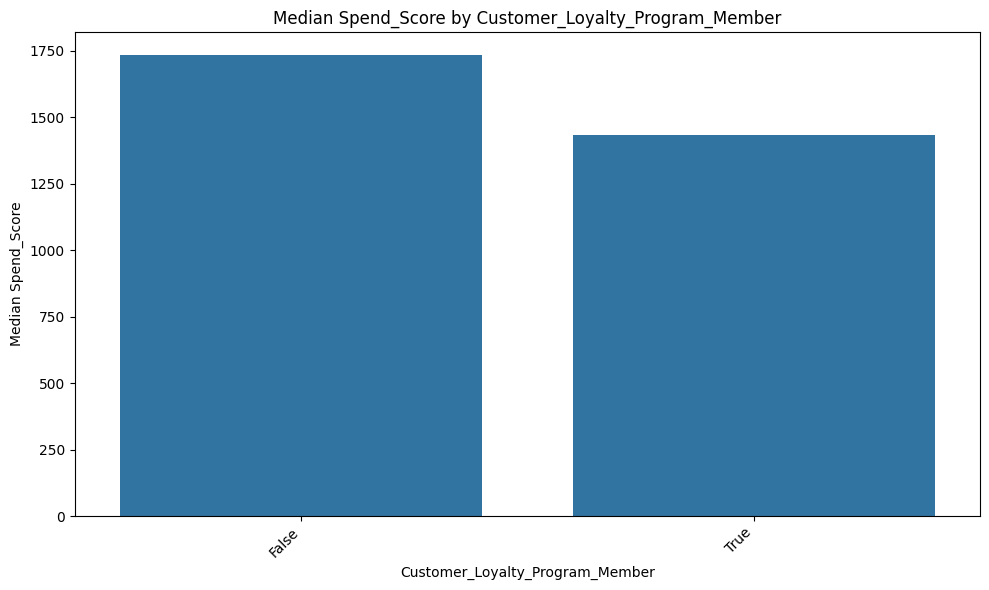

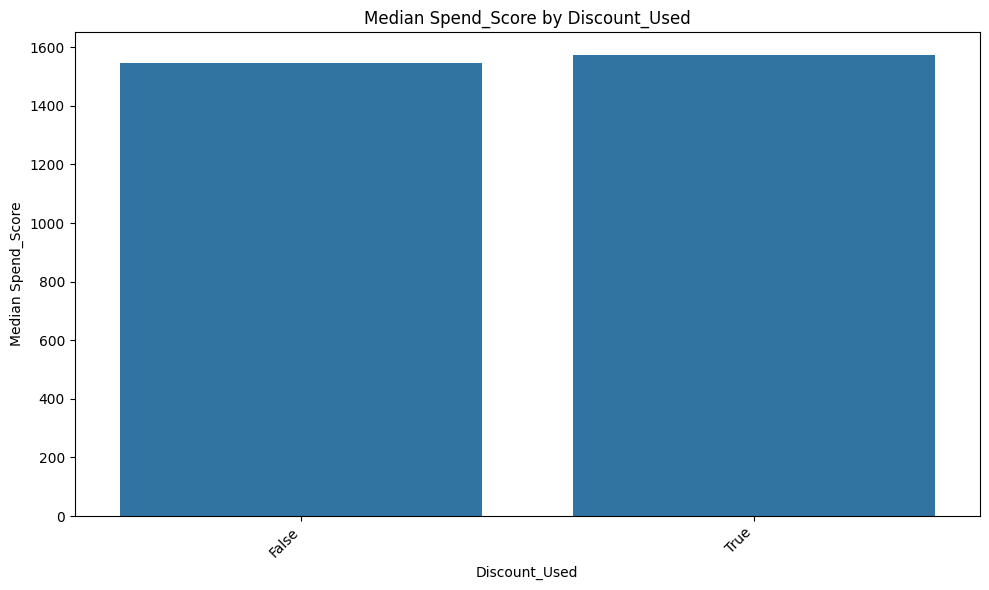

In [22]:
categorical_cols_to_plot = [
    'Purchase_Channel',
    'Social_Media_Influence',
    'Discount_Sensitivity',
    'Engagement_with_Ads',
    'Device_Used_for_Shopping',
    'Payment_Method',
    'Purchase_Intent',
    'Shipping_Preference',
    'Gender',
    'Income_Level',
    'Marital_Status',
    'Education_Level',
    'Occupation',
    'Customer_Loyalty_Program_Member',
    'Discount_Used'
]

for col in categorical_cols_to_plot:
    if col in customer.columns:
        median_spend = customer.groupby(col)['Spend_Score'].median().sort_values(ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x=median_spend.index, y=median_spend.values)
        plt.title(f'Median Spend_Score by {col}')
        plt.xlabel(col)
        plt.ylabel('Median Spend_Score')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
    else:
        print(f'Skip')

In [23]:
correlations = customer.corr(numeric_only=True)['Spend_Score']

correlations.sort_values(ascending=False)

Spend_Score                              1.000000
Purchase_Amount                          0.701846
Frequency_of_Purchase                    0.639935
Time_to_Decision                         0.048272
Discount_Used                            0.015355
Time_Spent_on_Product_Research(hours)   -0.003725
Customer_Satisfaction                   -0.007687
Product_Rating                          -0.028344
Return_Rate                             -0.028368
Age                                     -0.033743
Brand_Loyalty                           -0.051236
Customer_Loyalty_Program_Member         -0.084159
Name: Spend_Score, dtype: float64

# <font color='blue'> Predictive Modelling:

## Random Forest Classification

              precision    recall  f1-score   support

        High       0.08      0.02      0.03        56
         Low       0.31      0.14      0.19        81
      Medium       0.43      0.77      0.55       113

    accuracy                           0.40       250
   macro avg       0.27      0.31      0.26       250
weighted avg       0.31      0.40      0.32       250



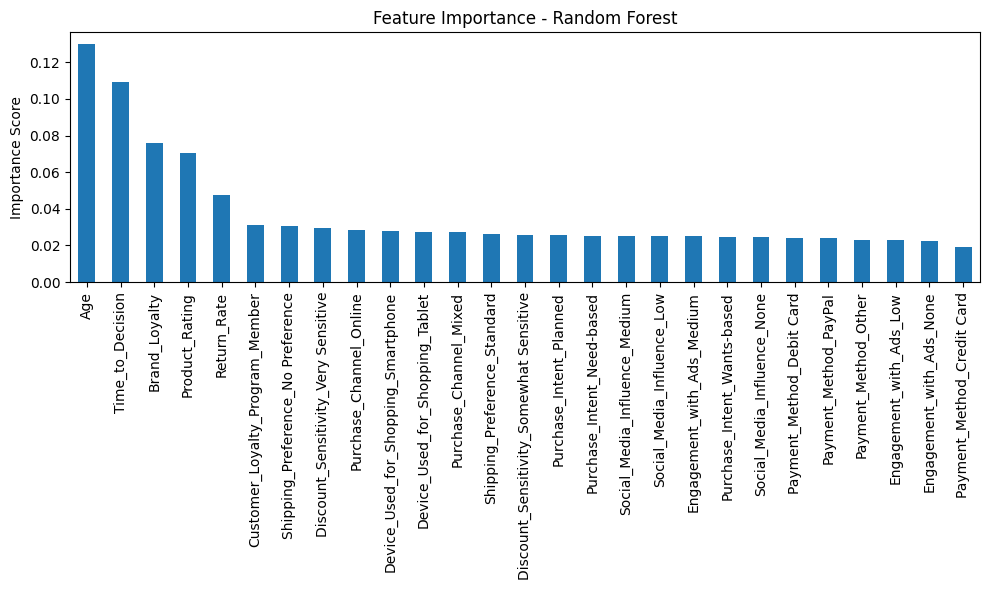

In [24]:
# Binning Spend_Score into 3 groups
def label_spend(score):
    if score < 1000:
        return 'Low'
    elif score < 3000:
        return 'Medium'
    else:
        return 'High'

customer['Spend_Label'] = customer['Spend_Score'].apply(label_spend)

behave_features = [
    'Purchase_Channel', 'Social_Media_Influence', 'Discount_Sensitivity',
    'Engagement_with_Ads', 'Device_Used_for_Shopping', 'Payment_Method',
    'Purchase_Intent', 'Shipping_Preference'
]

behave_dummies = pd.get_dummies(customer[behave_features], drop_first=True)

feature_cols = ['Time_to_Decision', 'Product_Rating', 'Return_Rate', 'Age', 'Brand_Loyalty', 'Customer_Loyalty_Program_Member']
X = pd.concat([customer[feature_cols], behave_dummies], axis=1)
y = customer['Spend_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

clf = RandomForestClassifier(random_state=123)
clf.fit(X_train, y_train)

#Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.plot(kind='bar')
plt.title('Feature Importance - Random Forest')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

Trying a binary classification

              precision    recall  f1-score   support

        High       0.00      0.00      0.00        54
    Not_High       0.78      0.99      0.88       196

    accuracy                           0.78       250
   macro avg       0.39      0.50      0.44       250
weighted avg       0.61      0.78      0.69       250



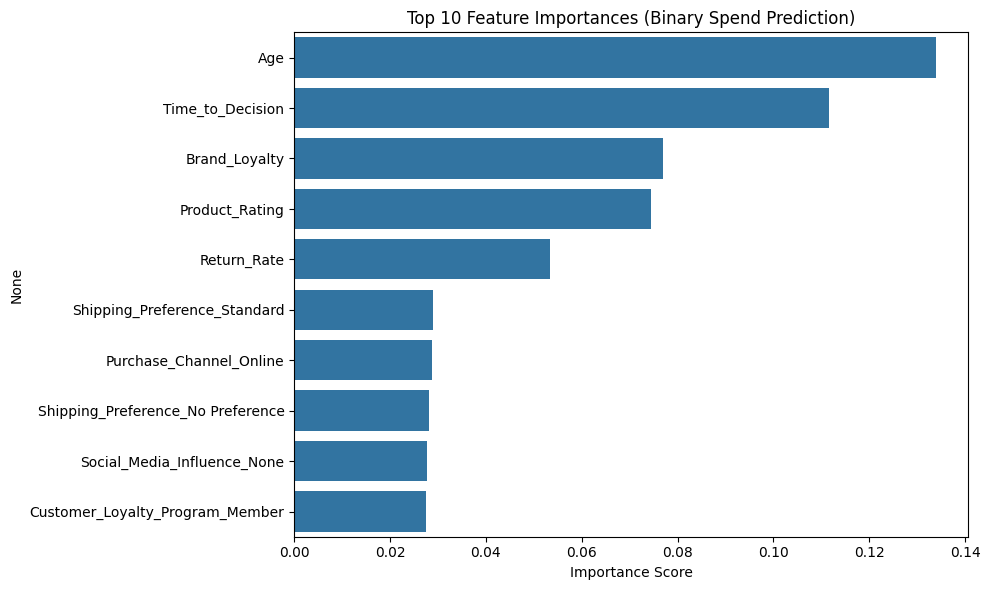

In [25]:
# Label as High or Not_High
def spend_binary(score):
    return 'High' if score > 3000 else 'Not_High'

customer['Spend_Binary'] = customer['Spend_Score'].apply(spend_binary)

# One-hot encoding
behave_features = [
    'Purchase_Channel', 'Social_Media_Influence', 'Discount_Sensitivity', 'Engagement_with_Ads',
    'Device_Used_for_Shopping', 'Payment_Method', 'Purchase_Intent', 'Shipping_Preference'
]

customer_encoded = pd.get_dummies(customer, columns=behave_features, drop_first=True)

features_for_model = [
    'Time_to_Decision', 'Product_Rating', 'Return_Rate', 'Age', 'Brand_Loyalty',
    'Customer_Loyalty_Program_Member'
] + [col for col in customer_encoded.columns if any(feat in col for feat in behave_features)]

X = customer_encoded[features_for_model]
y = customer_encoded['Spend_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

clf = RandomForestClassifier(class_weight='balanced', random_state=123)
clf.fit(X_train, y_train)

#Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 10 Feature Importances (Binary Spend Prediction)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [26]:
# Using SMOTE to synthetically balance the dataset
smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

clf.fit(X_resampled, y_resampled)
y_pred = clf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        High       0.14      0.06      0.08        54
    Not_High       0.78      0.90      0.83       196

    accuracy                           0.72       250
   macro avg       0.46      0.48      0.46       250
weighted avg       0.64      0.72      0.67       250



In [27]:
# Using Spend_Binary instead of Spend_Label
customer = customer.drop(columns='Spend_Label')

In [28]:
customer.to_csv("customer_with_spend_score.csv", index=False)

In [29]:
top_features

Age                                  0.133990
Time_to_Decision                     0.111562
Brand_Loyalty                        0.076873
Product_Rating                       0.074499
Return_Rate                          0.053346
Shipping_Preference_Standard         0.028968
Purchase_Channel_Online              0.028756
Shipping_Preference_No Preference    0.028053
Social_Media_Influence_None          0.027731
Customer_Loyalty_Program_Member      0.027447
dtype: float64

Using only top features for a binary classification model

In [30]:
customer_base = customer.copy()

# List of categorical features to encode
cat_features = ['Income_Level', 'Education_Level', 'Marital_Status', 
                'Purchase_Channel', 'Social_Media_Influence', 'Engagement_with_Ads', 
                'Device_Used_for_Shopping', 'Payment_Method', 
                'Purchase_Intent', 'Shipping_Preference', 'Discount_Sensitivity']

# One-hot encode the categorical variables
cat_dummies = pd.get_dummies(customer_base[cat_features], drop_first=True)

# Drop the original categorical columns and add dummies
customer_base = customer_base.drop(columns=cat_features)
customer_encoded = pd.concat([customer_base, cat_dummies], axis=1)

In [31]:
print(customer_encoded.columns.tolist())

['Customer_ID', 'Age', 'Gender', 'Occupation', 'Purchase_Category', 'Purchase_Amount', 'Frequency_of_Purchase', 'Brand_Loyalty', 'Product_Rating', 'Time_Spent_on_Product_Research(hours)', 'Return_Rate', 'Customer_Satisfaction', 'Time_of_Purchase', 'Discount_Used', 'Customer_Loyalty_Program_Member', 'Time_to_Decision', 'Spend_Score', 'Spend_Binary', 'Income_Level_Middle', 'Education_Level_High School', "Education_Level_Master's", 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Widowed', 'Purchase_Channel_Mixed', 'Purchase_Channel_Online', 'Social_Media_Influence_Low', 'Social_Media_Influence_Medium', 'Social_Media_Influence_None', 'Engagement_with_Ads_Low', 'Engagement_with_Ads_Medium', 'Engagement_with_Ads_None', 'Device_Used_for_Shopping_Smartphone', 'Device_Used_for_Shopping_Tablet', 'Payment_Method_Credit Card', 'Payment_Method_Debit Card', 'Payment_Method_Other', 'Payment_Method_PayPal', 'Purchase_Intent_Need-based', 'Purchase_Intent_Planned', 'Purchase_Intent_Wa

              precision    recall  f1-score   support

        High       0.00      0.00      0.00        56
    Not_High       0.77      0.96      0.86       194

    accuracy                           0.75       250
   macro avg       0.38      0.48      0.43       250
weighted avg       0.60      0.75      0.66       250



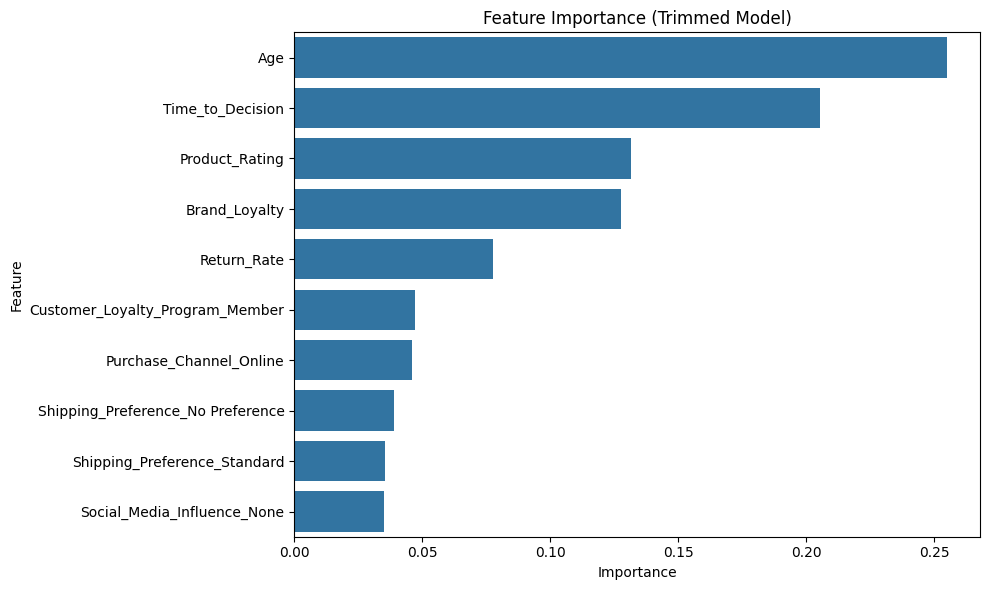

In [32]:
top_features = [
    'Age',
    'Time_to_Decision',
    'Brand_Loyalty',
    'Product_Rating',
    'Return_Rate',
    'Shipping_Preference_Standard',
    'Purchase_Channel_Online',
    'Shipping_Preference_No Preference',
    'Social_Media_Influence_None',
    'Customer_Loyalty_Program_Member',
]

X_trimmed = customer_encoded[top_features]
y_trimmed = customer_encoded['Spend_Binary']

X_train, X_test, y_train, y_test = train_test_split(X_trimmed, y_trimmed, test_size=0.25, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
clf = RandomForestClassifier(random_state=123)
clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Feature Importance Plot
importances = clf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': top_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance (Trimmed Model)')
plt.tight_layout()
plt.show()

Binary model with SMOTE using top 10 features ['Spend_Binary' as y]

              precision    recall  f1-score   support

        High       0.83      0.77      0.80       196
    Not_High       0.79      0.84      0.81       197

    accuracy                           0.81       393
   macro avg       0.81      0.81      0.81       393
weighted avg       0.81      0.81      0.81       393



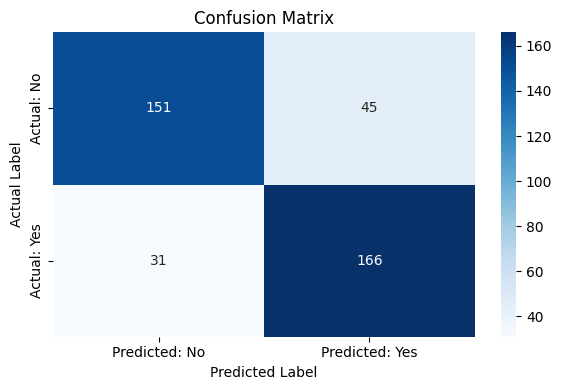

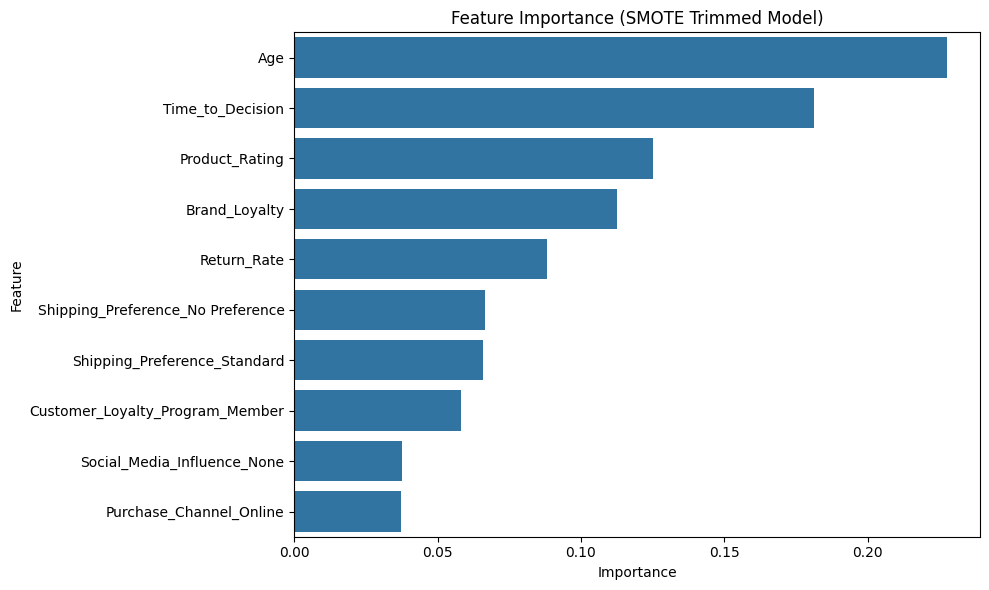

In [ ]:
smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X_trimmed, y_trimmed)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
clf = RandomForestClassifier(random_state=123)
clf.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted: No', 'Predicted: Yes'],
            yticklabels=['Actual: No', 'Actual: Yes'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Feature Importance Plot
importances = clf.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X_trimmed.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance (SMOTE Trimmed Model)')
plt.tight_layout()
plt.show()

Tuning Hyperparameters

In [34]:
param_grid = {
    'n_estimators': [100, 150, 200], # number of trees 
    'max_depth': [None, 10, 20], # depth of trees
    'min_samples_split': [2, 4, 6], # minimum number of samples to split a node
}

clf = RandomForestClassifier(random_state=123)

grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           cv=3, # 3-fold cross-validation to train model 3 times 
                           scoring='f1_macro',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

# Evaluate best model
rf_best_model = grid_search.best_estimator_
y_pred = rf_best_model.predict(X_test_scaled)

importances = rf_best_model.feature_importances_

print("Best Parameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

        High       0.83      0.77      0.80       196
    Not_High       0.79      0.84      0.81       197

    accuracy                           0.81       393
   macro avg       0.81      0.81      0.81       393
weighted avg       0.81      0.81      0.81       393



**The best-performing combination was the model's default parameters: n_estimators = 100, max_depth = None, min_samples_split = 2**

The Random Forest model achieved: Accuracy: 81%, Precision (High Spenders): 83%, Recall (High Spenders): 77%

## XGBoost (with SMOTE)

In [35]:
X_trimmed = customer_encoded[top_features]

# Encode labels: changing from 'High', 'Not_High' to 1 and 0
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_trimmed)


smote = SMOTE(random_state=123)
X_resampled, y_resampled = smote.fit_resample(X_trimmed, y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
xgb.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_xgb = xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79       196
           1       0.78      0.82      0.80       197

    accuracy                           0.79       393
   macro avg       0.79      0.79      0.79       393
weighted avg       0.79      0.79      0.79       393



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [11:38:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Tuning Hyperparameters

In [37]:
xgb = XGBClassifier(eval_metric='logloss', random_state=123)

param_grid = {
    'n_estimators': [100, 200, 300], # number of boosting rounds (trees)
    'max_depth': [3, 6, 10], #depth of trees
    'learning_rate': [0.1, 0.2, 0.3]  # how much to adjust weights each round
}

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           cv=3,
                           scoring='f1_macro',
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro', verbose=1)

**The best-performing combination was: n_estimators = 200, max_depth = 6, learning_rate = 0.1**

The XGBoost model achieved: Accuracy: 79%, Precision (High Spenders): 78%, Recall (High Spenders): 81%

Compared to the Random Forest model, accuracy and precision lowered by 2% and 5%, but recall incrased by 4%.

## K-Nearest Neighbour

In [156]:
# Fit model
knn = KNeighborsClassifier()  # default n_neighbors=5
knn.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       196
           1       0.72      0.69      0.70       197

    accuracy                           0.71       393
   macro avg       0.71      0.71      0.71       393
weighted avg       0.71      0.71      0.71       393



Tuning Hyperparameters

In [157]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'], # distance gives more influence to closer points
    'metric': ['euclidean', 'manhattan'] # manhattan uses city-block distance 
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='f1_macro', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)

# Predict and evaluate
y_pred_knn = grid_search.best_estimator_.predict(X_test_scaled)
print(classification_report(y_test, y_pred_knn))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.71      0.79      0.74       196
           1       0.76      0.68      0.72       197

    accuracy                           0.73       393
   macro avg       0.73      0.73      0.73       393
weighted avg       0.73      0.73      0.73       393



**The best-performing combination was: n_neighbors = 11, weights = distance, metric = manhattan**

The KNN model achieved: Accuracy: 73%, Precision (High Spenders): 76%, Recall (High Spenders): 68%

All three metrics are not as good compared to Random Forest or XGBoost, maybe because the model struggles with high dimensionality and is sensitive to feature scaling and irrelevant features.

## Final Model: XGBoost tuned
Higher recall means that the model might catch more high spenders, but if the company wishes to prioritise cost-efficiency over reach, random forest model should be used.

In [159]:
import joblib

# Save the best model and scaler to use for Streamlit
joblib.dump(best_xgb, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']